In [1]:
using DelimitedFiles
using LinearAlgebra
using PyPlot
include("functions/num2color.jl");

## 0. Choose protein and prevalence landscape

In [2]:
####################################################################################################
# To edit this code:
# * change protein, polyprotein, polyprotein1
####################################################################################################

protein="p24"
polyprotein="gag"
polyprotein1="Gag"
L=231;

In [3]:
ising_params0=readdlm("p24 landscape/p24-g2-0.0005-b-5870-gh-0.001/p24-out-learn.j")

# convert to square matrix
ising_params=zeros(L,L)
for i=1:L
    ising_params[i,i]=ising_params0[i]
end
for i=1:L
    for j=i+1:L
        ising_params[i,j]=ising_params0[round(Int,L+(L-1)*L/2-(L-i)*(L-i+1)/2+(j-i))]
        ising_params[j,i]=ising_params[i,j]
    end
end

## I. Choose patient

In [4]:
####################################################################################################
# To edit this code:
# * change patientid
####################################################################################################

patientid="CH058"
# patientid="CH077"
# patientid="CH159"

patientnames=Dict(
    "CH040"=>"700010040",
    "CH058"=>"700010058",
    "CH077"=>"700010077",
    "CH470"=>"700010470",
    "CH607"=>"700010607",
    "CH131"=>"703010131",
    "CH159"=>"703010159",
    "CH256"=>"703010256",
    "CH042"=>"704010042",
    "CH067"=>"705010067",
    "CH162"=>"705010162",
    "CH185"=>"705010185",
    "CH198"=>"705010198",
    "CH164"=>"706010164",
    "CAP045"=>"CAP45",
    "CAP210"=>"CAP210",
    "CAP239"=>"CAP239")

patient=patientnames[patientid]

"700010058"

## II. Parse patient's sequences from fasta file

In [5]:
####################################################################################################
# Output:
# * headersall, sequencesall
# * headers, sequences, lenseq, numseq, timepoints, numsamples
####################################################################################################

include("functions/parse_fasta_file.jl")
include("functions/parse_patient_sequences.jl")

# read and parse fasta file
protfilename="patient data/chavi-"*patient*"-aa-"*protein*".fasta"
headersall, sequencesall=read_fasta_file(protfilename)
headers, sequences=remove_hxb2_fasta(headersall,sequencesall)
lenseq=length(sequences[1])
numseq=length(sequences)
timepoints, numsamples=parse_patient_headers(headers);

The first header contains "HXB2". Returning only subsequent headers and sequences.


In [6]:
####################################################################################################
# Output:
# * polyheadersall, polysequencesall
# * polyheaders, polysequences, polylenseq, polynumseq, polytimepoints, polynumsamples
# * polyprotstart : location in the 1st polyprotein sequence where the 1st protein sequence is found, or 0 if not found

# Find starting position of 1st protein sequence within 1st polyprotein sequence
# NOTE: if polyprotstart=0, this means that there are multiple sequences at the initial timepoint,
#       and the order of the samples is different between protein and polyprotein
# 6/21/15: find starting position of p24 within gag using the gag fasta file
# 6/21/16: generalize to any HIV polyprotein
####################################################################################################

# read and parse polyprotein fasta file
polyfilename="patient data/chavi-"*patient*"-aa-"*polyprotein*".fasta"
polyheadersall, polysequencesall=read_fasta_file(polyfilename)
polyheaders, polysequences=remove_hxb2_fasta(polyheadersall,polysequencesall)
polylenseq=length(polysequences[1])
polynumseq=length(polysequences)
polytimepoints, polynumsamples=parse_patient_headers(polyheaders)

# find the starting index that the string sequences[1] is found in polysequences[1]
polyprotstart=findfirst(sequences[1],polysequences[1])[1]

The first header contains "HXB2". Returning only subsequent headers and sequences.


133

### (Ising) binarysequences

In [7]:
####################################################################################################
# Output:
# * binarysequences, binary_noncons_vs_time, binary_noninit_vs_time
####################################################################################################

consseq="PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTNNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANPDCKTILKALGPAATLEEMMTACQGVGGPGHKARVL"

binarysequences, binary_noncons_vs_time, binary_noninit_vs_time=parse_aa2binary(sequences,lenseq,numseq,consseq)

[binary_noncons_vs_time binary_noninit_vs_time timepoints numsamples]

16×4 Array{Any,2}:
 [27, 91, 107, 120, 225]           Int64[]      8  6
 [27, 91, 107, 120, 225]           Int64[]     45  7
 [27, 91, 107, 116, 120, 225]      [116]       45  1
 [27, 91, 107, 110, 120, 225]      [110]       45  1
 [27, 91, 107, 120, 225]           Int64[]     85  1
 [27, 91, 107, 116, 120, 225]      [116]       85  6
 [27, 91, 107, 110, 120, 225]      [110]       85  2
 [27, 91, 107, 110, 120, 225]      [110]      154  2
 [27, 91, 107, 116, 120, 225]      [116]      154  5
 [27, 91, 107, 110, 120, 225]      [110]      239  7
 [27, 91, 92, 107, 116, 120, 225]  [92, 116]  239  1
 [27, 91, 107, 110, 120, 225]      [110]      252  7
 [27, 91, 92, 107, 116, 120, 225]  [92, 116]  252  1
 [11, 27, 91, 107, 110, 120, 225]  [11, 110]  350  1
 [15, 27, 91, 107, 110, 120, 225]  [15, 110]  350  1
 [27, 91, 107, 110, 120, 225]      [110]      350  2

## III. Parse patient's epitopes from epitope file

In [8]:
####################################################################################################
# Output:
# * alleptinprotein, alleptstart, alleptend, allept, alleptstarttime
####################################################################################################

include("functions/parse_epitopes.jl")

eptfilename="patient data/epitopes-"*patient*".dat"
alleptinprotein, alleptstart, alleptend, allept, alleptstarttime=parse_epitope_file(eptfilename)

(AbstractString["Gag", "Gag", "Gag", "Env", "Nef"], [147, 162, 240, 584, 116], [155, 172, 249, 592, 124], AbstractString["ISPRTLNAW", "KAFSPEVIPMF", "TSTLQEQIGW", "ERYLRDQQL", "HTQGYFPDW"], [21, 595, 21, 21, 21])

In [9]:
####################################################################################################
# Input:
# * polyprotstart
# * alleptinprotein, alleptstart, alleptend, allept, alleptstarttime

# Output:
# * proteptstart, proteptend, protept, proteptstarttime

# Obtain start and end sites of epitopes within protein, starting with the polyprotein sequence
# 6/21/15: obtain epitope start and end sites within p24, for epitopes within Gag
# 6/21/16: generalize to any HIV polyprotein
# 9/9/16: output start time too
# 9/9/16: do not include epitopes that are beyond a certain start time
####################################################################################################

timethresh=500

# initialize proteptstart, proteptend, protept
proteptstart=Int[]
proteptend=Int[]
protept=AbstractString[]
proteptstarttime=Int[]

# search through alleptinprotein for instances of polyprotein1
for k=1:length(alleptinprotein)
    if alleptinprotein[k]==polyprotein1
        # check if polyprotein epitope is within protein

        proteptstarttemp=alleptstart[k]-polyprotstart+1
        proteptendtemp=alleptend[k]-polyprotstart+1

        if proteptstarttemp>0 && proteptendtemp<lenseq
            # 9/9/16: do not include epitopes that are beyond a certain start time
            if alleptstarttime[k]<timethresh
                push!(proteptstart,proteptstarttemp)
                push!(proteptend,proteptendtemp)
                push!(protept,allept[k])
                push!(proteptstarttime,alleptstarttime[k])
            else
                println("Epitope "*string(proteptstarttemp)*"..."*string(proteptendtemp)*" not included.")
            end
        end
    end
end

num_ept=length(protept)

# CHECK that amino acids of protept[i] are given in sequences[1]
for k=1:num_ept
    searchept=findfirst(protept[k],sequences[1])[1]
    if searchept!=proteptstart[k]
        println("ERROR: protept[$k] from epitope file is different from the amino acids in sequences[1].")
    end
end

proteptstart, proteptend, protept, proteptstarttime

Epitope 30...40 not included.


([15, 108], [23, 117], AbstractString["ISPRTLNAW", "TSTLQEQIGW"], [21, 21])

### (Ising) obtain binary version of protept

In [10]:
####################################################################################################
# Output:
# * proteptbinary
####################################################################################################

proteptbinary=Array[]
for k=1:num_ept
    push!(proteptbinary,binarysequences[proteptstart[k]:proteptend[k],1])
end
proteptbinary

2-element Array{Array,1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0]   
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## visualizations of fitness landscape

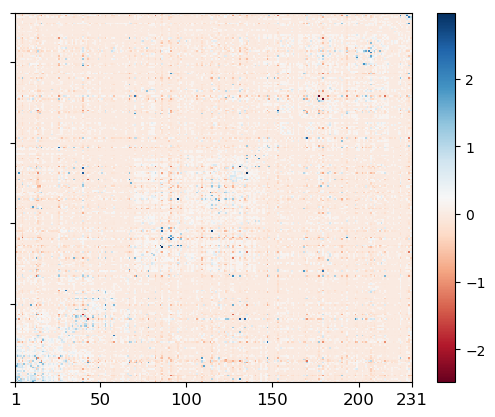

In [11]:
# 5/9/18: pcolor of Ising landscape

ising_params2=ising_params[:,:]
for i=1:L
    ising_params2[i,i]=0
end

heatmap=pcolor(ising_params2,cmap="RdBu")
xlim([1,L])
ylim([1,L])
xticks([1,50,100,150,200,231],fontsize="large")
# xlabel("site",fontsize="x-large")
yticks([1,50,100,150,200,231],fontsize="large")
ax1 = gca()
setp(ax1.get_yticklabels(),visible=false) # Disable y tick labels
colorbar()
# cbar=colorbar(heatmap)
# cbar.set_label("\$J_{ij}\$", rotation=270,fontsize="x-large")
# title("\$J_{ij}\$",fontsize="x-large");

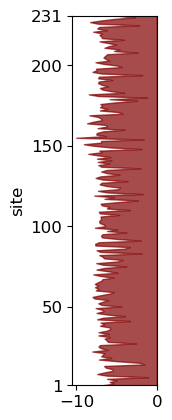

In [12]:
# 180515: visualization of h_i's

fill_betweenx(1:L,0,diag(ising_params),color="maroon",alpha=0.7)

ax=gca()
ax.set_aspect(0.2)
xmin,xmax=ax.get_xlim()
xlim(xmin,0)
ylim(1,L)
xticks(fontsize="large")
ylabel("site",fontsize="large")
yticks([1,50,100,150,200,231],fontsize="large")
# xlabel("\$h_i\$",fontsize="x-large");

In [13]:
# 181111: choose beta such that relative fitness costs are ~10%
beta=0.023
Jbeta=beta*ising_params

F_0=1.6;

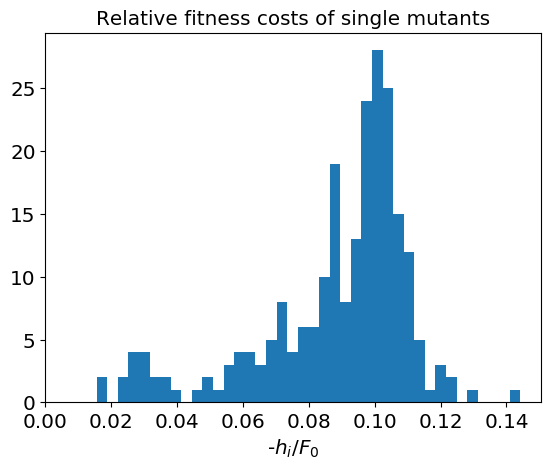

In [14]:
# 181027: histogram of relative fitness of single mutants

# hist(diag(Jbeta)/F_0,40)
# title("Relative fitness of single mutants",fontsize="x-large")
# xlabel("\$h_i/F_0\$",fontsize="x-large")

hist(-diag(Jbeta)/F_0,40)
title("Relative fitness costs of single mutants",fontsize="x-large")
xlabel("-\$h_i/F_0\$",fontsize="x-large")
# ylabel("count",fontsize="x-large")

# hist(-diag(Jbeta),40)
# title("Fitness costs of single mutants",fontsize="x-large")
# xlabel("-\$\\beta h^p_i\$ (day\$^{-1}\$)",fontsize="x-large")

# hist(log.(-diag(Jbeta))/log(10),40)
# title("Log-fitness costs of single mutants",fontsize="x-large")

xticks(fontsize="x-large")
yticks(fontsize="x-large")
ax=gca()
xmin,xmax=ax.get_xlim()
xlim(0,xmax);

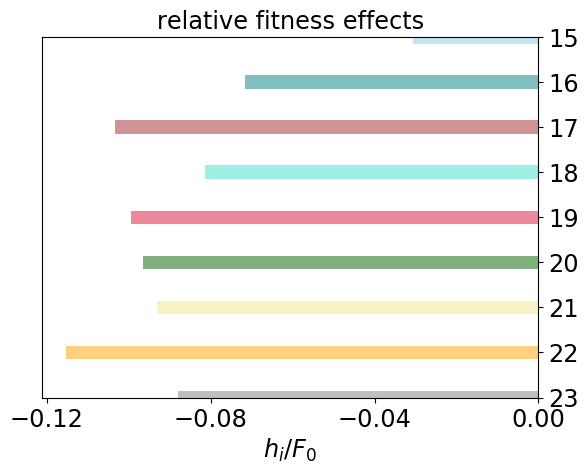

In [15]:
# 180516: visualization of h_i's restricted to epitopes

eptnum=1

# 180517: use barh

colorvec=String[]
for i=proteptstart[eptnum]:proteptend[eptnum]
    push!(colorvec,num2color(i))
end

barh(proteptstart[eptnum]:proteptend[eptnum],
    diag(Jbeta)[proteptstart[eptnum]:proteptend[eptnum]]/F_0,color=colorvec,height=0.3,alpha=0.5)

# scatter(diag(Jbeta)[15]/F_0,15,color="red",s=100)
scatter(diag(Jbeta)[110]/F_0,110,color="red",s=100)
scatter(diag(Jbeta)[116]/F_0,116,color="red",s=100)

title("relative fitness effects",fontsize="xx-large")
xlabel("\$h_i/F_0\$",fontsize="xx-large")
ax=gca()
ax.set_aspect(0.011)
xmin,xmax=ax.get_xlim()
xlim(xmin,0)
ylim(proteptstart[eptnum],proteptend[eptnum])
ax.invert_yaxis()
xticks([-0.12,-0.08,-0.04,0],fontsize="xx-large")
ax.yaxis.tick_right()
yticks(collect(proteptstart[eptnum]:proteptend[eptnum]),fontsize="xx-large");

In [16]:
include("functions/get_fitness_ept.jl") # contains: get_fitness(), get_fitness_ept()

# 181027: find all double mutants
fitnessdoublemut=Float64[]
for i=1:L, j=i+1:L
    tempseq=zeros(L)
    tempseq[i]=1
    tempseq[j]=1
    push!(fitnessdoublemut,get_fitness(Jbeta,tempseq))
end

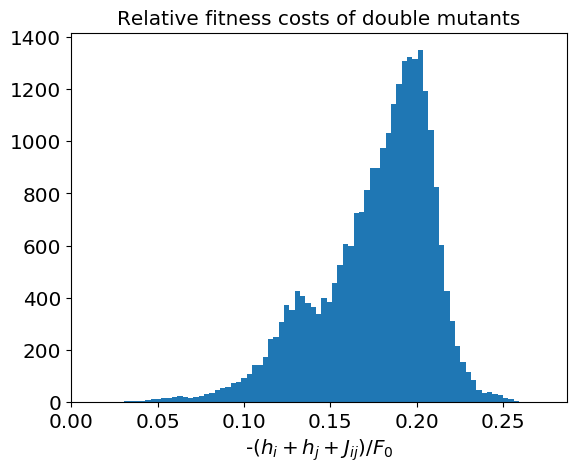

In [17]:
# 181027: histogram of relative fitness of double mutants

# hist(-fitnessdoublemut,80)
# title("Fitness costs of double mutants",fontsize="x-large")
# xlabel("-\$\\beta (h^p_i+h^p_j+J^p_{ij})\$ (day\$^{-1}\$)",fontsize="x-large")

hist(-fitnessdoublemut/F_0,80)
title("Relative fitness costs of double mutants",fontsize="x-large")
xlabel("-\$(h_i+h_j+J_{ij})/F_0\$",fontsize="x-large")

xticks(fontsize="x-large")
yticks(fontsize="x-large")
ax=gca()
xmin,xmax=ax.get_xlim()
xlim(0,xmax);

## (1) EMF

In [18]:
include("functions/find_peak.jl") # contains: find_peakest_stop(), find_peak()
include("functions/get_fitness_ept.jl") # contains: get_fitness(), get_fitness_ept()
include("functions/run_EMF_Ising_3.jl")
include("functions/find_pops.jl") # contains: find_pops()
include("functions/find_outcome.jl") # contains: find_outcome()
# include("functions/estimate_t_ext.jl") # contains: estimate_t_ext();

### 181028: NL4-3

In [19]:
# HXB2gag="MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAVNPGLLETSEGCRQILGQLQPSLQTGSEELRSLYNTVATLYCVHQRIEIKDTKEALDKIEEEQNKSKKKAQQAAADTGHSNQVSQNYPIVQNIQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRVHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTNNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANPDCKTILKALGPAATLEEMMTACQGVGGPGHKARVLAEAMSQVTNSATIMMQRGNFRNQRKIVKCFNCGKEGHTARNCRAPRKKGCWKCGKEGHQMKDCTERQANFLGKIWPSYKGRPGNFLQSRPEPTAPPEESFRSGVETTTPPQKQEPIDKELYPLTSLRSLFGNDPSSQ"
NL43gag="MGARASVLSGGELDKWEKIRLRPGGKKQYKLKHIVWASRELERFAVNPGLLETSEGCRQILGQLQPSLQTGSEELRSLYNTIAVLYCVHQRIDVKDTKEALDKIEEEQNKSKKKAQQAAADTGNNSQVSQNYPIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTHNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANPDCKTILKALGPGATLEEMMTACQGVGGPGHKARVLAEAMSQVTNPATIMIQKGNFRNQRKTVKCFNCGKEGHIAKNCRAPRKKGCWKCGKEGHQMKDCTERQANFLGKIWPSHKGRPGNFLQSRPEPTAPPEESFRFGEETTTPSQKQEPIDKELYPLASLRSLFGSDPSSQ"
NL43seq=NL43gag[132+1:132+L]

NL43sites=Int[]
for i=1:L
    if NL43seq[i]!=consseq[i]
        push!(NL43sites,i)
    end
end

NL43binaryseq=zeros(Int,L)
for i in NL43sites
    NL43binaryseq[i]=1
end

### Create matrix of mutation rates

In [20]:
# 181101: construct nucMutMat
nucVec=['A','T','C','G']
nucMutMat=[0    3e-6 5e-6   1.6e-5; # from Zanini-2017
           7e-7 0    1.2e-5 2e-6  ;
           9e-7 1e-5 0      1e-7  ;
           6e-6 3e-6 5e-7   0     ]
for j=1:4
    nucMutMat[j,j]=1-sum(nucMutMat[:,j])
end
sum(nucMutMat,dims=1)

1×4 Array{Float64,2}:
 1.0  1.0  1.0  1.0

In [21]:
# 181101: check that CH58 nucleotide sequence is equivalent to sequences[1]
include("functions/codon2aa.jl")

CH58nucseq="CCTATAGTGCAGAACCTTCAGGGGCAAATGGTACATCAGGCCATATCGCCTAGAACTTTAAATGCATGGGTAAAAGTAATAGAAGAGAAGGCTTTCAGCCCAGAAGTGATACCCATGTTTTCAGCATTATCAGAAGGAGCCACCCCACAAGATTTAAACACCATGCTAAACACAGTGGGGGGACACCAAGCAGCTATGCAAATGTTAAAAGAAACCATCAATGAGGAAGCTGCAGAATGGGATAGACTACATCCAGTACATGCAGGGCCTGCTGCACCAGGCCAGATGAGAGAACCAAGGGGAAGTGACATAGCAGGATCTACTAGTACCCTTCAGGAACAAATAGGATGGATGACAAGTAATCCACCTATTCCAGTAGGAGAGATCTATAAAAGATGGATAATCCTGGGATTAAATAAAATAGTAAGGATGTATAGTCCTACTAGCATTCTGGACATAAGACAAGGACCAAAAGAACCCTTTAGAGACTATGTAGACCGGTTCTATAAAACTCTAAGAGCCGAGCAAGCCTCACAGGAGGTAAAAAATTGGATGACAGAAACCTTGTTGGTCCAAAATGCAAACCCAGATTGTAAAACTATTTTAAAAGCATTGGGACCAGCAGCTACACTAGAAGAAATGATGACAGCATGTCAGGGAGTGGGAGGACCCAGCCATAAAGCAAGGGTTTTG"
testseq0=Char[]
for i=1:L
    push!(testseq0,codon2aa(CH58nucseq[(i-1)*3+1:(i-1)*3+3]))
end
testseq=join(testseq0)

sequences[1]==testseq

true

In [22]:
# 181101: construct muArray from CH58 nucleotide sequence
muArray=zeros(L,2)
for i=1:L # i labels codons
    this_codon=CH58nucseq[(i-1)*3+1:(i-1)*3+3]
    this_aa=codon2aa(this_codon)
    
    if binarysequences[i,1]==0 # s_i=0; find the total mutation probability to another aa
        for j=1:3 # each residue j=1:3 to mutate
            n0=findall(in(this_codon[j]),nucVec)[1] # identify unmutated nucleotide
            for n=1:4 # each nucleotide nucVec[1:4] to mutate site j to
                if n!=n0
                    codon2=join([this_codon[1:j-1],nucVec[n],this_codon[j+1:3]]) # replace residue j with mutated nucleotide
                    if codon2aa(codon2)!=this_aa # mutation in amino acid space occurred
                        muArray[i,1]+=nucMutMat[n,n0] # row is TO nucleotide, column is FROM nucleotide
                    end
                end
            end
        end
    else # binarysequences[i,1]==1 # s_i=1
        cons_aa=consseq[i]
        
        # mutate nucleotides of this_codon one-by-one, and find all cons_codons a distance of one mutation away
        num_sol=0
        for j=1:3 # each residue j=1:3 to mutate
            n0=findall(in(this_codon[j]),nucVec)[1] # identify unmutated nucleotide
            for n=1:4 # each nucleotide nucVec[1:4] to mutate site j to
                if n!=n0
                    codon2=join([this_codon[1:j-1],nucVec[n],this_codon[j+1:3]]) # replace residue j with mutated nucleotide
                    if codon2aa(codon2)==cons_aa # single mutation results in consensus aa
                        num_sol+=1
                        muArray[i,2]+=nucMutMat[n,n0] # row is TO nucleotide, column is FROM nucleotide
                    end
                end
            end
        end
        
        # if consensus is NOT one mutation away
        if num_sol==0
            println("Error: consensus amino acid is >1 nucleotide mutations from initial codon at site $i. Manually input value.")
        end
    end
end

# 181101: put in muArray[91,2] by hand
muArray[91,2]=1.92e-10

# 181101: add a small constant to all rates
muArray.+=1e-15;

Error: consensus amino acid is >1 nucleotide mutations from initial codon at site 91. Manually input value.


### Parameter values

In [23]:
# 181027: redefining parameter values
mu=3.6e-5
tf=500
beta=0.023
Jbeta=beta*ising_params

# seqinit=zeros(L)
# seqinit=NL43binaryseq
seqinit=binarysequences[:,1]

# 181027: redefining F_0 and b_tot
F_0=1.6
b_tot=-6

# 12/13/16: define N_0
N_0=10

# 181027: naive response kinetics
t_0_naive=7
t_half_naive=7
n_Hill_naive=2
t_vec_naive=collect(t_0_naive:tf)
b_Hill_vec_naive=(t_vec_naive.-t_0_naive).^n_Hill_naive./
                 (t_half_naive^n_Hill_naive.+(t_vec_naive.-t_0_naive).^n_Hill_naive)
ept_field=b_tot/num_ept*vcat(zeros(t_0_naive),b_Hill_vec_naive)

# 2/13/17: estimate tpeak, Npeak, and find t_zone, N_stop
tpeak_est, Npeak_est, t_zone, N_stop=find_peakest_stop(tf,N_0,F_0,num_ept,ept_field)

(11, 1.106405641893542e8, 18, 10000)

### EMF

In [25]:
@time hEff_inf_dmf1, m_inf_dmf1,=run_EMF_Ising_3(L,mu,tf,Jbeta,seqinit,
# @time hEff_inf_dmf1_muArray, m_inf_dmf1_muArray,=run_EMF_Ising_3(L,muArray,tf,Jbeta,seqinit,
            ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field,ept_init=proteptbinary)

  0.043367 seconds (17.04 k allocations: 29.069 MiB, 15.18% gc time)


([-0.148285 -0.148277 … -0.16717 -0.167167; -0.103809 -0.103801 … -0.129057 -0.129041; … ; -0.0157142 -0.0157193 … -0.089327 -0.0893115; -0.109402 -0.1094 … -0.10157 -0.101574], [0.0 3.10388e-5 … 0.000197792 0.000197796; 0.0 3.24504e-5 … 0.000260989 0.000261023; … ; 0.0 3.54387e-5 … 0.000384603 0.000384649; 0.0 3.22694e-5 … 0.000336749 0.000336738], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Deterministic population dynamics

In [26]:
# 181101: compute NVec_inf

t2=50
mean_fitness_ept,=get_fitness_ept(Jbeta,m_inf_dmf1[:,1:t2+1],proteptstart,proteptend,proteptbinary,ept_field[1:t2+1])
NVec_inf=find_pops(L,mu,t2,N_0,F_0,hEff_inf_dmf1[:,1:t2+1],m_inf_dmf1[:,1:t2+1],mean_fitness_ept);

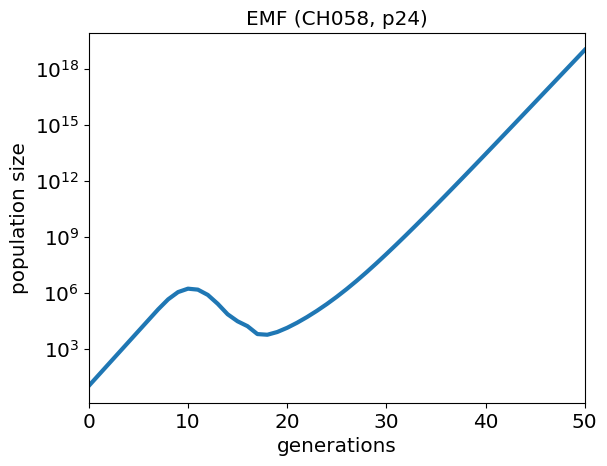

In [27]:
# 180519: plot population size vs. time

semilogy(0:t2,NVec_inf[1:t2+1],linewidth=3)

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("population size",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(0,t2)
ax=gca()
ymin,ymax=ax.get_ylim()
ylim(0,ymax);

### 181127: compute NVec for a range of btot

In [28]:
t2=30
btot_range=collect(-8:1:-4)
num_range=length(btot_range)
NVec_range=zeros(t2+1,num_range)
for i=1:num_range
    b=btot_range[i]
    ept_fieldb=b/num_ept*vcat(zeros(t_0_naive),b_Hill_vec_naive)
    
    hEff_inf_dmf1b, m_inf_dmf1b,=run_EMF_Ising_3(L,mu,tf,Jbeta,seqinit,
            ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_fieldb,ept_init=proteptbinary)
    
    mean_fitness_eptb,=get_fitness_ept(Jbeta,m_inf_dmf1b[:,1:t2+1],proteptstart,proteptend,proteptbinary,ept_fieldb[1:t2+1])
    NVec_range[:,i]=find_pops(L,mu,t2,N_0,F_0,hEff_inf_dmf1b[:,1:t2+1],m_inf_dmf1b[:,1:t2+1],mean_fitness_eptb)
end

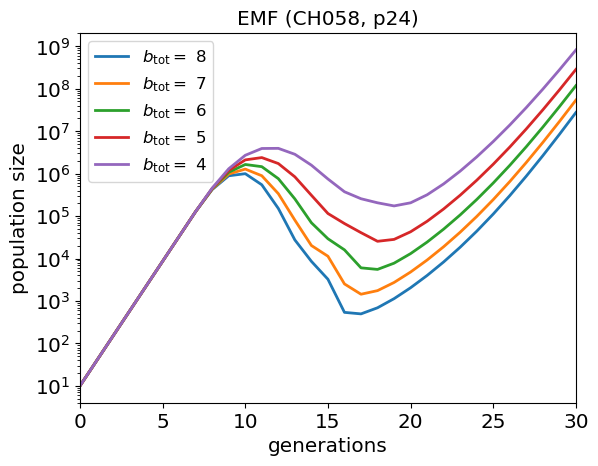

In [29]:
legendnames=String[]
for i=1:num_range
    semilogy(NVec_range[:,i],linewidth=2); push!(legendnames,"\$b_{\\mathrm{tot}}=\$ $(-btot_range[i])")
end

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("population size",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(0,t2)
ax=gca()
ymin,ymax=ax.get_ylim()
ylim(0,ymax)
boxloc=[0,1]
legend(legendnames, loc="upper left", bbox_to_anchor=boxloc, borderaxespad=0.5, fontsize="large");

## Stochastic population dynamics

In [31]:
# 180522: compute stochastic EMF population dynamics

N_stop2=round(Int,1e15)
t_zone2=0

@time hEff_stoc_dmf1, m_stoc_dmf1, NVec=run_EMF_Ising_3(L,mu,tf,Jbeta,seqinit,
            ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field,ept_init=proteptbinary,
            newept=0,finitepop=2,N_0=N_0,F_0=F_0,N_stop=N_stop2,t_zone=t_zone2)

outcome, t1=find_outcome(t_zone2,tf,NVec,N_stop2)

  0.010964 seconds (23.67 k allocations: 5.641 MiB)


("escape", 45)

In [32]:
# 180519: compute several stochastic population dynamics runs
# 180522: use larger N_stop2

num_runs=100
N_stop2=round(Int,1e15)
t_zone2=0

hEff_stoc_dmf1_allruns=zeros(L,tf+1,num_runs)
m_stoc_dmf1_allruns=zeros(L,tf+1,num_runs)
NVec_allruns=zeros(Int,tf+1,num_runs)
outcome_allruns=String[]
t1_allruns=zeros(Int,num_runs)
@time for n=1:num_runs
    hEff_stoc_dmf1, m_stoc_dmf1, NVec=run_EMF_Ising_3(L,mu,tf,Jbeta,seqinit,
            ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field,ept_init=proteptbinary,
            newept=0,finitepop=2,N_0=N_0,F_0=F_0,N_stop=N_stop2,t_zone=t_zone2)

    outcome, t1=find_outcome(t_zone2,tf,NVec,N_stop2)
    
    hEff_stoc_dmf1_allruns[:,:,n]=hEff_stoc_dmf1
    m_stoc_dmf1_allruns[:,:,n]=m_stoc_dmf1
    NVec_allruns[:,n]=NVec
    push!(outcome_allruns,outcome)
    t1_allruns[n]=t1
end

  1.416064 seconds (2.72 M allocations: 592.964 MiB, 19.56% gc time)


In [33]:
# 180522: find average m_stoc_dmf1 of num_runs runs
m_stoc_dmf1_average=sum(m_stoc_dmf1_allruns,dims=3)[:,:,1]/num_runs

# # 180821: also compute standard deviations at each site & time!
# m_stoc_dmf1_sd=sqrt.(sum( (m_stoc_dmf1_allruns-m_stoc_dmf1_average.*ones(m_stoc_dmf1_allruns)).^2,dims=3)[:,:,1]/num_runs);

In [83]:
# 180821: save stochastic runs data
writedlm("hEff_stoc_dmf1_allruns.dat",hEff_stoc_dmf1_allruns)
writedlm("m_stoc_dmf1_allruns.dat",m_stoc_dmf1_allruns)
writedlm("NVec_allruns.dat",NVec_allruns)
writedlm("outcome_allruns.dat",outcome_allruns)
writedlm("t1_allruns.dat",t1_allruns);

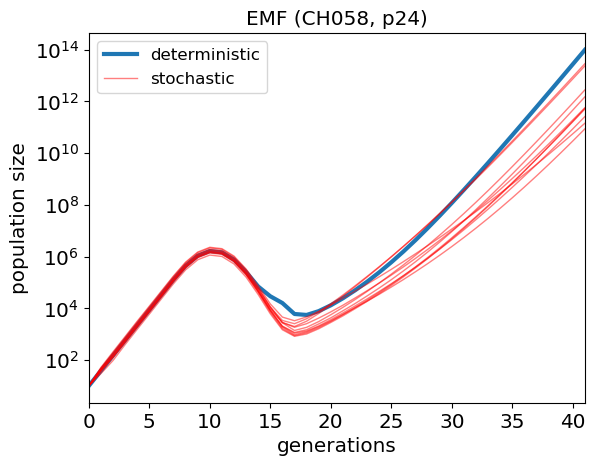

In [34]:
# 180519: plot population size vs. time

t2=minimum(t1_allruns)-1
# t2=t1

semilogy(0:t2,NVec_inf[1:t2+1],linewidth=3)
# semilogy(0:t1,NVec[1:t1+1],color="red",alpha=0.5)
for n=1:10
#     semilogy(0:t1_allruns[n],NVec_allruns[1:t1_allruns[n]+1,n],color="red",alpha=0.5,linewidth=1)
    semilogy(0:t2,NVec_allruns[1:t2+1,n],color="red",alpha=0.5,linewidth=1)
end

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("population size",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(0,t2)
ax=gca()
ymin,ymax=ax.get_ylim()
ylim(0,ymax)

legend(["deterministic","stochastic"],loc="upper left", bbox_to_anchor=[0,1], borderaxespad=0.5,fontsize="large");

## (1.1) Mutant frequencies

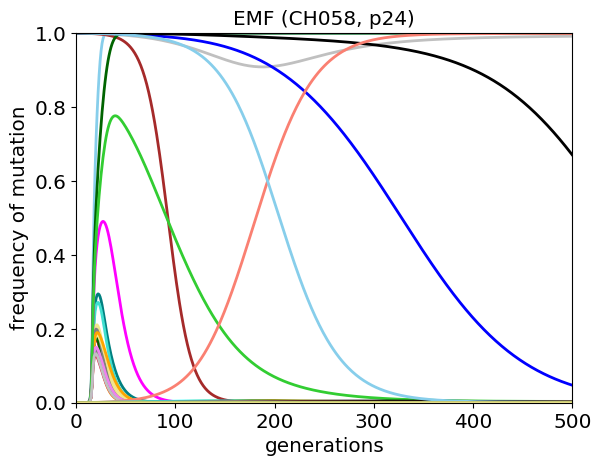

In [35]:
# 7/16/16: plot DMF result

t1=tf

# # 181111: choose a range of individual stochastic runs to plot
# run_range=1:10

# 180820: use smallest t1 among ALL runs so as to have a meaningful mean
# t1=minimum(t1_allruns)-1 # see e.g. XV.23 for why we subtract 1

site_range=1:L
# site_range=110
# site_range=[15,110,116]

## sites within epitopes
# eptnum=2; site_range=proteptstart[eptnum]:proteptend[eptnum]
# site_range=[collect(proteptstart[1]:proteptend[1]);collect(proteptstart[2]:proteptend[2])]

## sites outside epitopes
# site_range=1:proteptstart[1]-1
# site_range=proteptend[1]+1:proteptstart[2]-1
# site_range=proteptend[2]+1:L
# site_range=[collect(1:proteptstart[1]-1);collect(proteptend[1]+1:proteptstart[2]-1);collect(proteptend[2]+1:L)]

# site_range=binary_noncons_vs_time[1]

# # 180517: plot b(t) on the same plot
# b_of_t=cat(zeros(t_0_naive),b_Hill_vec_naive,dims=1)
# plot(0:t1,b_of_t[1:t1+1],linestyle="--",linewidth=2,color="yellow")
# legend(["\$b_{\\varepsilon}(t)/b_{\\varepsilon,0}\$"],loc="upper left", bbox_to_anchor=[0.7,1], borderaxespad=0.5,fontsize="large")

# # 180518: plot a specified set of sites first and include legend for them
# spec_sites=[27,91,107,120,148,225]
# spec_legendnames=AbstractString[]
# for site in spec_sites
#     plot(0:t1,m_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2); push!(spec_legendnames,string(site))
# #     plot(0:t1,m_inf_dmf1_muArray[site,1:t1+1],color=num2color(site),linewidth=2); push!(spec_legendnames,string(site))
# end
# # site=225; plot(0:t1,m_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2); push!(spec_legendnames,string(site))
# legend(spec_legendnames,loc="upper right", bbox_to_anchor=[1,1], borderaxespad=0.5,fontsize="large")

legendnames=AbstractString[]
for site in site_range
    plot(0:t1,m_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2); push!(legendnames,string(site))
#     plot(0:t1,m_inf_dmf1NL[site,1:t1+1],color=num2color(site),linewidth=2); push!(legendnames,string(site))
#     plot(0:t1,m_inf_dmf1_muArray[site,1:t1+1],color=num2color(site),linewidth=2); push!(legendnames,string(site))
end
# for site in site_range
#     plot(0:t1,m_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2,linestyle="--")
# end
# for site in site_range
#     # plot the mean among stochastic runs
#     plot(0:t1,m_stoc_dmf1_average[site,1:t1+1],color=num2color(site),linestyle="--",linewidth=2)#; push!(legendnames,string(site))
# #     errorbar(0:t1,m_stoc_dmf1_average[site,1:t1+1],m_stoc_dmf1_sd[site,1:t1+1],color=num2color(site),linestyle="--")#; push!(legendnames,string(site))
    
# #     for n=run_range
# #         plot(0:t1,m_stoc_dmf1_allruns[site,1:t1+1,n],color=num2color(site),linestyle=":",linewidth=2)#; push!(legendnames,string(site))
# #     end
# end

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("frequency of mutation",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(0,t1)
ylim(0,1)
if length(site_range)<=10
    boxloc=[0,1]
    legend(legendnames,loc="upper left", bbox_to_anchor=boxloc, borderaxespad=0.5,fontsize="large")
end;

In [36]:
# 180820: find site with largest mutant frequency for each run

eptnum=2; site_range=proteptstart[eptnum]:proteptend[eptnum]
hist_runs=zeros(size(site_range))

for n=1:num_runs
    max_site=findall(in(maximum(m_stoc_dmf1_allruns[site_range,t1_allruns[n],n])),m_stoc_dmf1_allruns[site_range,t1_allruns[n],n])[1]
    hist_runs[max_site]+=1
end

hist_runs

10-element Array{Float64,1}:
  1.0
  0.0
 56.0
  2.0
  0.0
  2.0
  1.0
 15.0
 22.0
  1.0

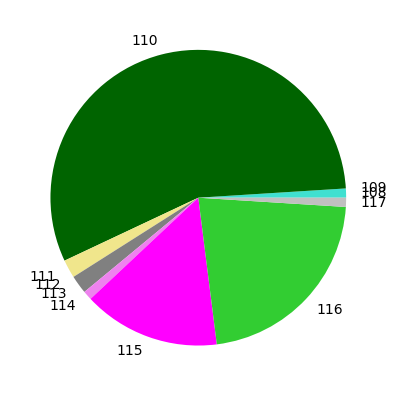

In [37]:
# 180820: create pie chart of largest-frequency mutations in epitope among the simulation runs

# 180821: create same color scheme as num2color()
ept_colors=String[]
for i in site_range
    push!(ept_colors,num2color(i))
end

pie(hist_runs,labels=collect(site_range),colors=ept_colors);

# Immunodominance

In [93]:
# 180517: implement immunodominance
immunod=[1/6,5/6]
ept_field_immunod=zeros(num_ept,tf+1)
for k=1:num_ept
    ept_field_immunod[k,:]=immunod[k]*b_tot*vcat(zeros(t_0_naive),b_Hill_vec_naive)
end

# run DMF, with initial population assumed to be comprised only of seqinit
# 10/13/16: include population-size feedback
@time hEff_immunod, infx_immunod,=run_EMF_Ising_3(L,mu,tf,Jbeta,seqinit,
            ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field_immunod,ept_init=proteptbinary)

  0.816759 seconds (852.30 k allocations: 65.543 MiB, 4.04% gc time)


([-0.154961 -0.154954 … -0.184645 -0.184632; -0.0916395 -0.091635 … -0.132439 -0.132417; … ; -0.0134591 -0.0134647 … -0.0917784 -0.0917681; -0.108672 -0.108671 … -0.0994939 -0.0994982], [0.0 3.08323e-5 … 0.00017742 0.000177433; 0.0 3.28477e-5 … 0.000253817 0.00025386; … ; 0.0 3.55187e-5 … 0.000374162 0.000374183; 0.0 3.2293e-5 … 0.000344163 0.00034415], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

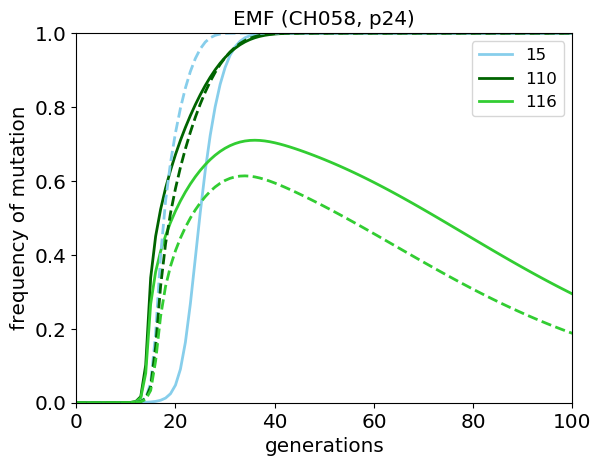

In [99]:
# 180518: plot infx_immunod

t1=100
# site_range=1:L
site_range=[15,110,116]

# plot(0:t1,infx_immunod[30,1:t1+1],color=num2color(30),linewidth=2)
# plot(0:t1,m_inf_dmf1[30,1:t1+1],color=num2color(30),linewidth=2,linestyle="--")

legendstring=AbstractString[]
for site in site_range
    plot(0:t1,infx_immunod[site,1:t1+1],color=num2color(site),linewidth=2); push!(legendstring,string(site))
end

for site in site_range
    plot(0:t1,m_inf_dmf1[site,1:t1+1],color=num2color(site),linestyle="--",linewidth=2)
end

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("frequency of mutation",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(0,t1)
ylim(0,1)

# legendstring=["\$b_1=b_2/5\$","\$b_1=b_2\$"]
legend(legendstring,loc="upper right", bbox_to_anchor=[1,1], borderaxespad=0.5,fontsize="large");

### Manually match with CH058 evolution

In [100]:
# 9/9/16: manually match with CH058 evolution

timepoints1=[8,45,85,154,239,350]
numsamples_tot=[6,9,9,7,8,4]
n_110=[0,1,2,2,7,4]
n_116=[0,1,6,5,1,0]
n_15=[0,0,0,0,0,1]
x_110=n_110./numsamples_tot
x_116=n_116./numsamples_tot
x_15=n_15./numsamples_tot;

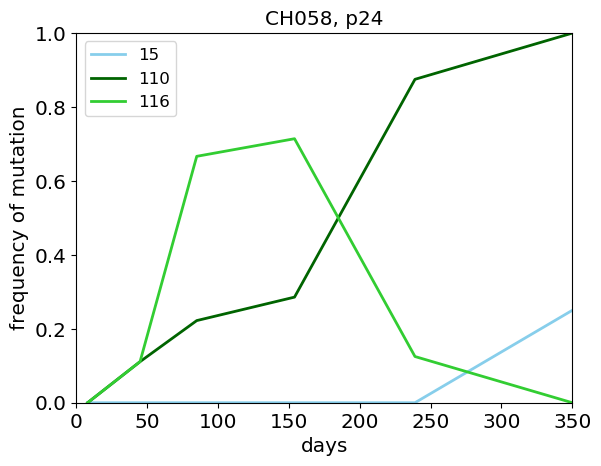

In [101]:
# 9/9/16: plot CH058 data

legendnames=AbstractString[]

plot(timepoints1,x_15,color=num2color(15),linewidth=2); push!(legendnames,string(15))
plot(timepoints1,x_110,color=num2color(110),linewidth=2); push!(legendnames,string(110))
plot(timepoints1,x_116,color=num2color(116),linewidth=2); push!(legendnames,string(116))

title("$patientid, $protein",fontsize="x-large")
xlabel("days",fontsize="x-large")
ylabel("frequency of mutation",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim([0,timepoints1[end]])
ylim([0,1])
legend(legendnames,loc="upper left", bbox_to_anchor=[0,1], borderaxespad=0.5,fontsize="large");

## (1.2) Effective fields

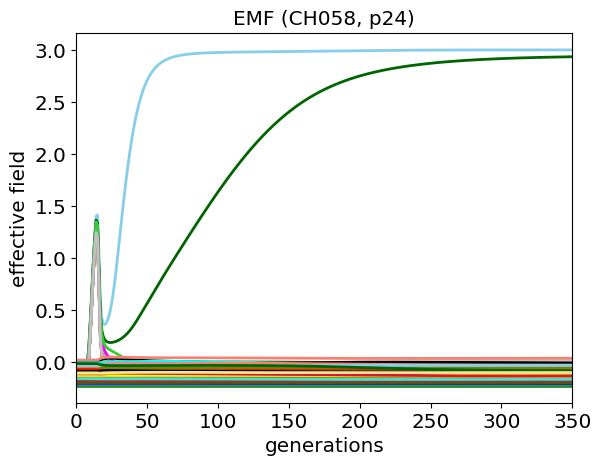

In [38]:
# 9/9/16: plot hEff_inf_dmf1

t1=350

site_range=1:L

## sites within epitopes
# eptnum=2; site_range=proteptstart[eptnum]:proteptend[eptnum]
# site_range=[collect(proteptstart[1]:proteptend[1]);collect(proteptstart[2]:proteptend[2])]

## sites outside epitopes
# site_range=1:proteptstart[1]-1
# site_range=proteptend[1]+1:proteptstart[2]-1
# site_range=proteptend[2]+1:L
# site_range=[collect(1:proteptstart[1]-1);collect(proteptend[1]+1:proteptstart[2]-1);collect(proteptend[2]+1:L)]

# site_range=binary_noncons_vs_time[1]

# # 180517: plot b(t) on the same plot
# b_of_t=cat(zeros(t_0_naive),b_Hill_vec_naive,dims=1)
# plot(0:t1,b_of_t[1:t1+1],linestyle="--",color="yellow",linewidth=2)
# legend(["\$b_{\\varepsilon}(t)/b_{\\varepsilon,0}\$"],loc="upper left", bbox_to_anchor=[0.7,1], borderaxespad=0.5,fontsize="large")

# # 180518: plot a specified set of sites first and include legend for them
# spec_sites=[15,110,116,148]
# spec_legendnames=AbstractString[]
# for site in spec_sites
#     plot(0:t1,hEff_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2); push!(spec_legendnames,string(site))
# end
# legend(spec_legendnames,loc="upper left", bbox_to_anchor=[0.78,1], borderaxespad=0.5,fontsize="large")

legendnames=AbstractString[]
for site in site_range
    plot(0:t1,hEff_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2); push!(legendnames,string(site))
    
#     # plot hEff - h_i
#     plot(0:t1,hEff_inf_dmf1[site,1:t1+1]-Jbeta[site,site],color=num2color(site),linewidth=2); push!(legendnames,string(site))
end

hlines(0,0,t1,color="darkgrey",alpha=0.5,linestyle="--",linewidth=2)

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("effective field",fontsize="x-large")
# ylabel("effective field - \$h_i\$",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(0,t1)
# ax=gca()
# ymin,ymax=ax.get_ylim()
# ylim(ymin,1)
if length(site_range)<=30
    boxloc=[0.9,1]
    legend(legendnames,loc="upper right", bbox_to_anchor=boxloc, borderaxespad=0.5,fontsize="large")
end;

## (1.3) Mean fitness & diversity

In [39]:
# 180515: calculate the mean fitness of the population
@time mean_fitness_ept,mean_fitness_noept=get_fitness_ept(Jbeta,m_inf_dmf1,
                                            proteptstart,proteptend,proteptbinary,ept_field);

  0.030302 seconds (4.58 k allocations: 8.863 MiB, 26.15% gc time)


In [40]:
# 180517: check that mean fitness is always nondecreasing
function is_nondecreasing(vec)
    for i=1:length(vec)-1
        if vec[i] - vec[i+1]>1e-12
            return false
        end
    end
    return true
end

is_nondecreasing (generic function with 1 method)

In [41]:
# 180517: check that mean fitness is always nondecreasing
is_nondecreasing(mean_fitness_ept[50+1:end]), is_nondecreasing(mean_fitness_noept[50+1:end])

(true, true)

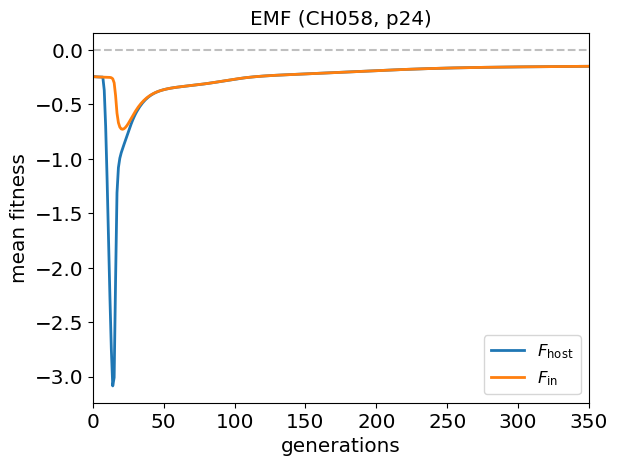

In [42]:
# 8/8/16: plot mean fitness as a function of time

tstart=0
t1=350

# for site in site_range
#     plot(0:t1,m_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2); push!(legendnames,string(site))
# end

plot(tstart:t1,mean_fitness_ept[tstart+1:t1+1],linewidth=2)
plot(tstart:t1,mean_fitness_noept[tstart+1:t1+1],linewidth=2)

hlines(0,0,t1,color="grey",alpha=0.5,linestyle="--")

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("mean fitness",fontsize="x-large")
ax=gca()
# xticksvec=ax.get_xticks()
# xticks(cat([50],xticksvec,dims=1),fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(tstart,t1)
boxloc=[1,0]
legend(["\$F_{\\mathrm{host}}\$","\$F_{\\mathrm{in}}\$"],loc="lower right", bbox_to_anchor=boxloc, borderaxespad=0.5,fontsize="large");

### entropy per site

In [43]:
# 180518: entropy per site
function entropy_per_site(m_inf_dmf1)
    entropy_all=m_inf_dmf1.*log.(m_inf_dmf1) + (1 .- m_inf_dmf1).*log.(1 .- m_inf_dmf1)
    for i=1:L, t=1:tf+1
        if isnan(entropy_all[i,t])==true
            entropy_all[i,t]=0
        end
    end
    return -sum(entropy_all,dims=1)'/L/log(2)
end

entropy_per_site (generic function with 1 method)

In [44]:
# 180518: entropy per site
H_per_site=entropy_per_site(m_inf_dmf1);

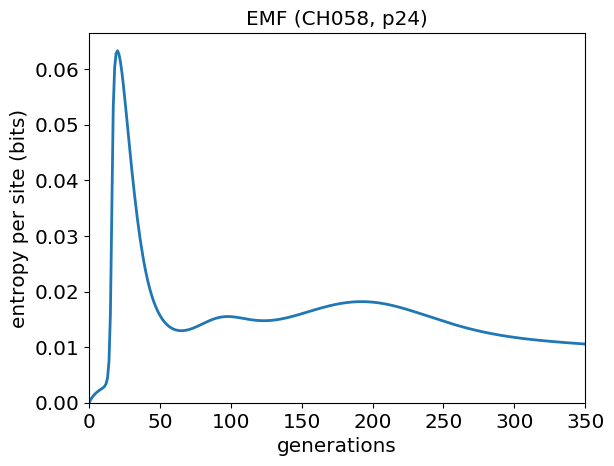

In [45]:
# 180518: plot entropy per site
tstart=0
t1=350
plot(0:t1,H_per_site[1:t1+1],linewidth=2)

# for site in site_range
#     plot(0:t1,m_inf_dmf1[site,1:t1+1],color=num2color(site),linewidth=2); push!(legendnames,string(site))
# end

title("EMF ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("entropy per site (bits)",fontsize="x-large")
# ax=gca()
# xticksvec=ax.get_xticks()
# xticks(cat([50],xticksvec,dims=1),fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(tstart,t1)
ax=gca()
ymin,ymax=ax.get_ylim()
ylim(0,ymax);